In [1]:
import os, glob
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from adjustText import adjust_text

In [2]:
pth = os.path.join('..', '..')
pth_data = os.path.join(pth, 'data')
pth_attr = os.path.join(pth_data, 'modeling', 'interpret')
pth_feat = os.path.join(pth_data, 'features', 'biomart')
pth_ref = os.path.join(pth_data, 'figures')
# pth_out = os.path.join(pth, 'figures', 'modeling')

In [3]:
adata = sc.read_h5ad(os.path.join(pth_attr, 'CCCA_malignant.h5ad'))
adata

AnnData object with n_obs × n_vars = 1434229 × 856
    obs: 'sample', 'cell_type', 'complexity', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top', 'mp_assignment', 'ebv', 'celltype', 'Title', 'Category', 'Disease', 'Technology', 'Samples', 'Cells ', 'Name', 'patient', 'cell_subtype', 'source', 'disease', 'p16_status', 'site', 't_stage', 'n_stage', 'gender', 'race', 'age', 'tobacco_use', 'alcohol_use', 'hpv', 'hpv_score', 'treatment', 'procedure', 'sorting', 'cluster', 'malignant', 'sample_id', 'cell_subtype_clusters', 'tnm_stage', 'treatment_exposure', 'treatment_response', 'cell_lineage', 'type', 'clusters_by_authors', 'cell_QCpass', 'is_tumor', 'cell_compartment', 'cluster_assignment', 'metastasis', 'sex', 'prior_enzalutamide', 'prior_abiraterone', 'prior_taxane', 'prior_platinum', 'prior_sipuleucel_T', 'purity', 'has_bulk_RNA', 'cancer_cell_state', 'PSA', 'source_region', 'gleason_score', 'ERG_status', 'cores', 'post_op_gleason_score', 'margin

In [4]:
feat_fn = sorted(glob.glob(os.path.join(pth_feat, '*.csv')))
df = pd.read_csv(os.path.join(pth_data, 'summary.csv'), index_col = 0)
get_source = lambda fn: os.path.split(fn)[1].replace('.csv', '')
feat_dict = {get_source(fn) : fn for fn in feat_fn if 'union' not in fn}
for src, fn in feat_dict.items():
    print(src)
    df_feat = pd.read_csv(fn)
    g = df_feat.mmusculus.copy()
    g = g.loc[g.isin(adata.var_names)]
    ig = adata[:, g].layers['IG_z'].sum(axis = 1)
    adata.obs[src] = np.asarray(ig).squeeze()

EMTHallmark
GSE136689
GSE162534
GSE201257
GSE229103
HCAEmbryonicHindlimb
rRNAModifications


In [5]:
# attributions — 3CA (diseases)
src_train = df.loc[df.Training == True].index
grp = adata.obs.groupby('Disease', observed = True)
z = grp.latent_z.mean().sort_values(ascending = False)
attr_cancer = grp[src_train].mean().loc[z.index]

# PCA decomposition — training celltypes
fn = os.path.join(pth_ref, 'attributions.csv')
attr = pd.read_csv(fn, index_col = [0, 1])
pca = PCA(n_components = 2).fit(attr)
attr_pca = pd.DataFrame(pca.fit_transform(attr),
                        index = attr.index,
                        columns = ['PC1', 'PC2'])

# PCA decomposition — 3CA diseases
attr_cancer_pca = pd.DataFrame(pca.fit_transform(attr_cancer),
                               index = attr_cancer.index,
                               columns = ['PC1', 'PC2'])

/tmp/ipykernel_4046606/345240190.py:48: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(*coords,
/tmp/ipykernel_4046606/345240190.py:48: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(*coords,


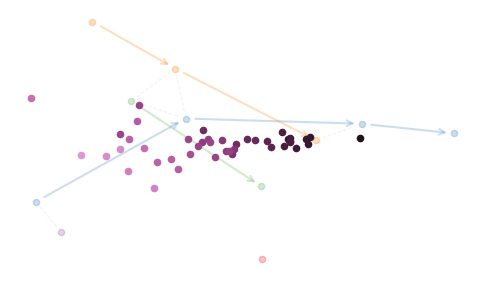

In [19]:
cmap = plt.cm.Set1; a, s = .25, 20
colors = {src : cmap(i) for i, src in enumerate(src_train)}

arrowprops = {
    'arrowstyle' : '->',
    'linewidth'  : 1.5,
    'alpha'      : a,
    'shrinkA'    : 7,
    'shrinkB'    : 5}

# plot attribution embedding
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
labels, objects = [], []
for src in src_train:
    X_src = attr_pca.loc[src]
    c = colors[src]
    arrowprops['color'] = c
    for i in range(X_src.shape[0]):
        coords = X_src.iloc[i]
        ax.scatter(*coords, s = s, color = c, alpha = a)
        if i > 0:
            coords_prev = X_src.iloc[i - 1]
            ax.annotate('', coords_prev, coords,
                        arrowprops = arrowprops)

arrowprops = {
    'arrowstyle' : '-',
    'linestyle'  : (0, (2, 2)),
    'color'      : 'lightgray',
    'alpha'      : a,
    'linewidth'  : 1,
    'shrinkA'    : 5,
    'shrinkB'    : 5}

# annotate celltype clusters
D = pairwise_distances(attr_pca)
D[np.tril_indices(D.shape[0])] = np.nan
ix, jx = np.where(D < .075)
for i in range(ix.size):
    coords0 = attr_pca.iloc[ix[i]]
    coords1 = attr_pca.iloc[jx[i]]
    objects.append(
        ax.annotate('', coords0, coords1,
                    arrowprops = arrowprops))

for i in range(attr_cancer.shape[0]):
    coords = attr_cancer_pca.iloc[i]
    ax.scatter(*coords,
               s = s,
               c = plt.cm.vanimo(z.loc[attr_cancer.index[i]]),
               vmin = 0, vmax = 1,
               zorder = 1000)
    # labels.append(
    #     ax.text(*coords,
    #             attr_cancer_pca.index[i],
    #             size = 5,
    #             color = 'k',
    #             zorder = 100))

# adjust labels
# plt.margins(.4, .4)
# adjust_text(labels, add_objects = objects, arrowprops = {'arrowstyle' : '-', 'color' : 'r', 'linewidth' : 1})
# plt.margins(.1, .1)

# label_dict = {
#     'Neuromesodermal Progenitor' : 'Neuromesodermal\nProgenitor'}

# pos_dict = {
#     'Epiblast'                   : (-.005, 0),
#     'Posterior Epiblast'         : (.005, -.0075),
#     'Lateral Plate Mesoderm'     : (0, .005),
#     'Nascent Endothelium'        : (.01, 0),
#     'Migratory Neural Crest'     : (.155, 0),
#     'Cranial Mesenchyme'         : (.075, -.0075),
#     'Neuromesodermal Progenitor' : (-.0035, -.01),
#     'Presomitic Mesoderm'        : (.0025, 0),
#     'Limb Mesenchyme'            : (.0035, 0),
#     'Splanchnic Mesoderm'        : (.0025, 0)}

# for label in ax.texts:
#     _label_ = label.get_text()
#     x, y = label.get_position()
#     if _label_ in label_dict:
#         label.set_text(label_dict[_label_])
#     if _label_ in pos_dict:
#         dx, dy = pos_dict[_label_]
#         label.set_position([x + dx, y + dy])

ax.set_aspect(1); ax.axis(False)
# fn = os.path.join(pth_out, 'interpret.pdf')
# plt.savefig(fn, bbox_inches = 'tight')
plt.show()

In [17]:
attr_cancer_pca.sort_values('PC1', ascending = False).head(20)

,PC1,PC2
Disease,,
Small Cell Lung Cancer,0.173532,0.006871
Pancreatic Ductal Adenocarcinoma,0.114797,0.008399
High-Grade Glioma,0.112884,0.000429
Acute Myeloid Leukemia,0.110941,0.005860
Medulloblastoma,0.098888,-0.004963
Kidney Cancer,0.091899,0.003182
Chronic Lymphocytic Leukemia,0.091564,0.006909
Metastatic Melanoma,0.091119,0.004188
Melanoma,0.089713,0.006241
